# Pedestrian Crash - Classification

Binary classification on the model with boundary 800.

## Import the necessary modules

In [1]:
from pathlib import Path
from src.dataset_reader import DatasetReaderCSV
from src.utilities import to_scrollable_table
from src.plot import plot_car_attributes, plot_pedestrian_attributes, plot_hic_value, plot_validation_acc_values
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Read the dataset

I am reading the dataset from a file.
I've previously exported the dataset using another script.

In [2]:
path = Path("C:\\Users\geork\projects\AIThesis\src\datasets\crash_simulation_classification.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Position"], errors="ignore")

In [3]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
df = df.drop(columns=to_remove_features)

## Dataset Insights

### Dataset Head

In [4]:
print(df.head())

  CarProfile  Velocity  Translation  Rotation  HIC15_max
0        FCR       100         -200         0     86.843
1        FCR       100         -200       120   2361.697
2        FCR       100         -200       150    573.455
3        FCR       100         -200       180     84.702
4        FCR       100         -200       210    592.965


### Dataset description

In [5]:
print(df.describe())

          Velocity  Translation     Rotation      HIC15_max
count  1200.000000  1200.000000  1200.000000    1200.000000
mean     60.000000     0.000000   165.000000   10594.607520
std      28.296064   282.960637   103.604754   28156.535615
min      20.000000  -400.000000     0.000000       0.000000
25%      40.000000  -200.000000    82.500000     444.451250
50%      60.000000     0.000000   165.000000    1826.896500
75%      80.000000   200.000000   247.500000    7791.743000
max     100.000000   400.000000   330.000000  277304.682000


### Dataset table

In [6]:
to_scrollable_table(df)

CarProfile,Velocity,Translation,Rotation,HIC15_max
FCR,100,-200,0,86.843
FCR,100,-200,120,2361.697
FCR,100,-200,150,573.455
FCR,100,-200,180,84.702
FCR,100,-200,210,592.965
FCR,100,-200,240,1235.194
FCR,100,-200,270,6257.955
FCR,100,-200,300,4974.677
FCR,100,-200,30,775.362
FCR,100,-200,330,440.203


### Car profile attributes

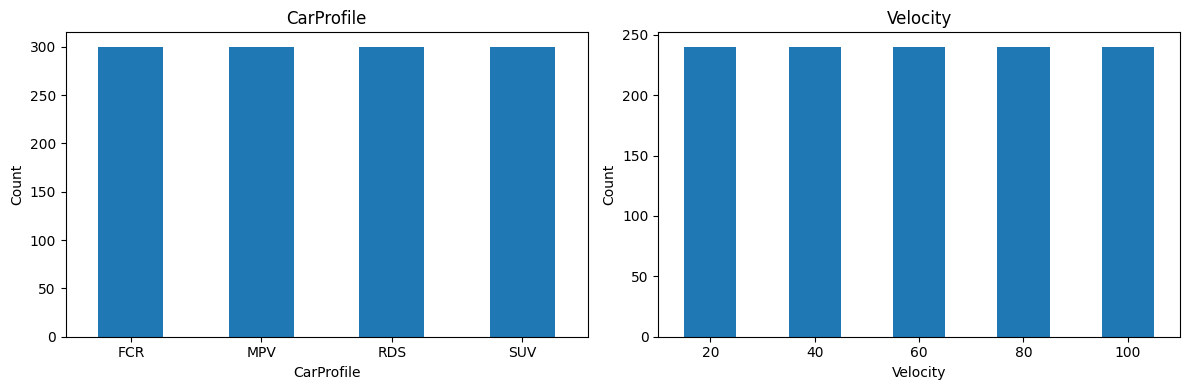

In [7]:
plot_car_attributes(df)

### Pedestrian attributes

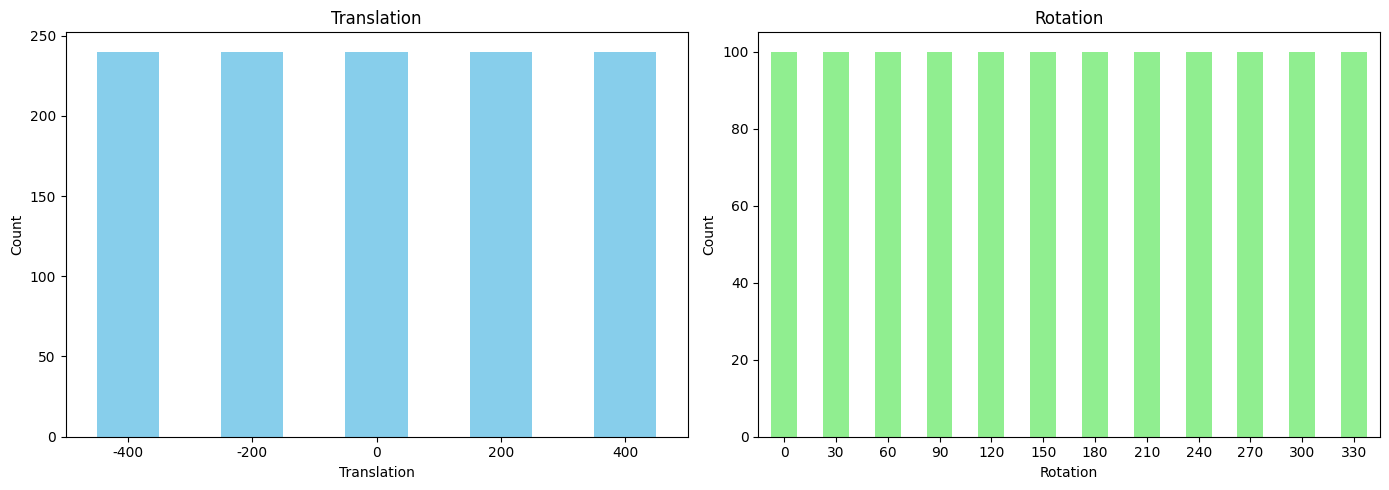

In [8]:
plot_pedestrian_attributes(df)

### Target attributes

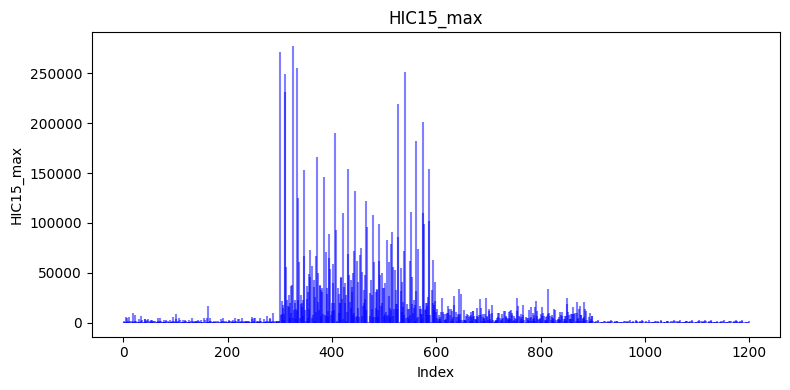

In [9]:
plot_hic_value(df, "HIC15_max")


### One-hot-encoding in CarProfile column

In [10]:
# One-hot encoding the 'CarProfile' column
df = pd.get_dummies(df, columns=['CarProfile'])

# Display the DataFrame after one-hot encoding
print("\nDataFrame after One-hot Encoding:")
print(df)


DataFrame after One-hot Encoding:
      Velocity  Translation  Rotation  HIC15_max  CarProfile_FCR  \
0          100         -200         0     86.843            True   
1          100         -200       120   2361.697            True   
2          100         -200       150    573.455            True   
3          100         -200       180     84.702            True   
4          100         -200       210    592.965            True   
...        ...          ...       ...        ...             ...   
1195        80          400       300    623.367           False   
1196        80          400        30    140.360           False   
1197        80          400       330    367.018           False   
1198        80          400        60   1317.014           False   
1199        80          400        90   1861.807           False   

      CarProfile_MPV  CarProfile_RDS  CarProfile_SUV  
0              False           False           False  
1              False           False  

## Binary classification (<800) HIC15_max

### Setup threshold

In [11]:
THRESHOLD = 800

### Create HIC15 binary

In [12]:
# Create a new target column for the classification
df_bin = df.copy()
df_bin["HIC15_over_800"] = (df["HIC15_max"] > 800).astype(int)
df_bin = df_bin.drop(columns=["HIC15_max"])

### Plot HIC15 thresholds

Entries over the threshold: 791
Entries under the threshold: 409


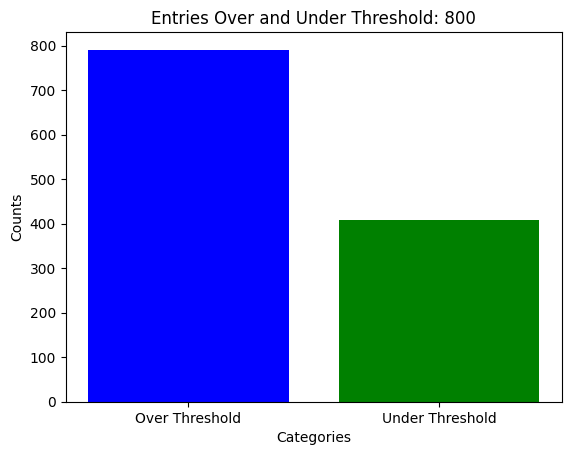

In [13]:
over_thres  = (df_bin["HIC15_over_800"] == True).sum()
under_thres = (df_bin["HIC15_over_800"] == False).sum()

print("Entries over the threshold:", over_thres)
print("Entries under the threshold:", under_thres)

# Data for the bar chart
categories = ['Over Threshold', 'Under Threshold']
counts = [over_thres, under_thres]

# Create the bar chart
plt.bar(categories, counts, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Entries Over and Under Threshold: 800')

# Show the plot
plt.show()

### Separate train/test sets

In [14]:
# Split the data into features and target
X = df_bin.drop(columns=["HIC15_over_800"])
y = df_bin["HIC15_over_800"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Apply normalization to the dataset

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training #1

In [16]:
# Step 7: Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6415 - loss: 0.6375 - val_accuracy: 0.7208 - val_loss: 0.5284
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6511 - loss: 0.5915 - val_accuracy: 0.7083 - val_loss: 0.5197
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6694 - loss: 0.5662 - val_accuracy: 0.7083 - val_loss: 0.5270
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6834 - loss: 0.5553 - val_accuracy: 0.7333 - val_loss: 0.5324
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6966 - loss: 0.5516 - val_accuracy: 0.7417 - val_loss: 0.5269
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7502 - loss: 0.5231 - val_accuracy: 0.7458 - val_loss: 0.5204
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7403 - loss: 0.5360 - val_accuracy: 0.7208 - val_loss: 0.5159
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7436 - loss: 0.5226 - val_accuracy: 0.7542 - val_loss:

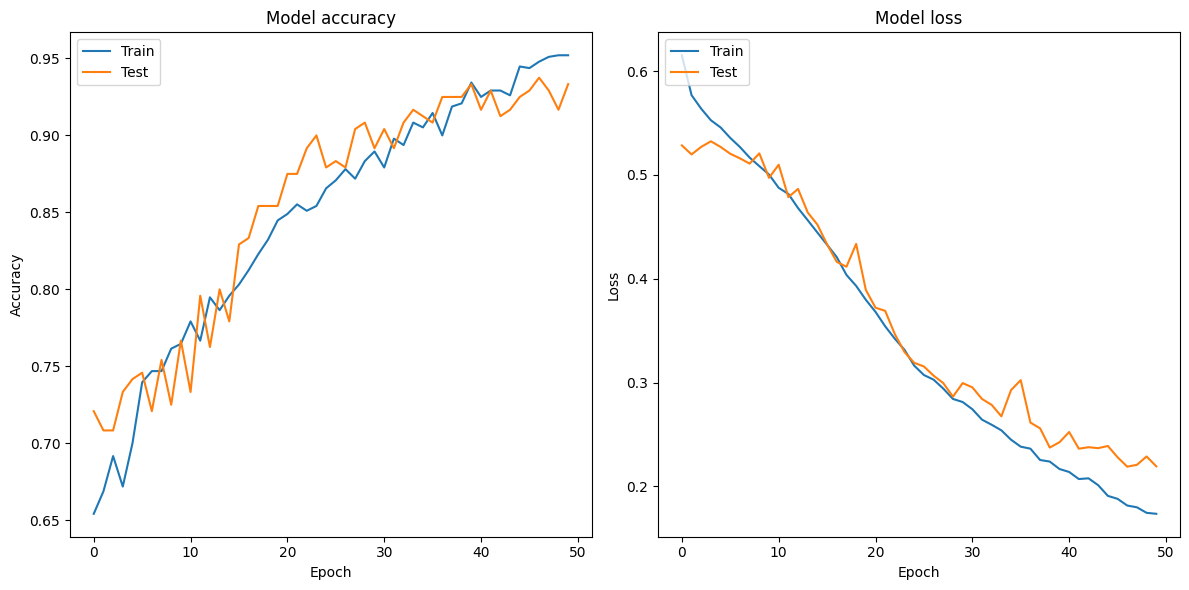

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


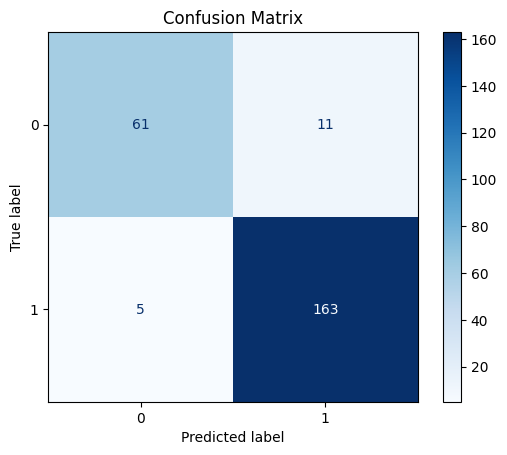

In [17]:
plot_validation_acc_values(history)

# Predict the classes of the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()